# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
from collections import Counter
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score
import joblib

# 2. Setting 

In [2]:
warnings.filterwarnings('ignore')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRITAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRITAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PRITAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRITAM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 3. Reading Data

In [7]:
# Function to get the data
Path = r"D:\SMS_SPAM_CLASSIFIER"
def get_data(file):
    filename = f"{file}.csv"
    filepath = os.path.join(Path,filename)
    return pd.read_csv(filepath,encoding='latin-1')

In [8]:
# Reading the dataset
data = get_data('spam')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
# Checking the shape
data.shape

(5572, 5)

In [10]:
# Checking the information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


- We don't need the last three columns as most of the values are null
- We will also rename the first two columns as 'target' and 'text'

In [11]:
# Checking if the dataset is balanced or not
data.v1.value_counts(normalize=True)

v1
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

- The dataset is imbalanced. The model should be with high Precision score

In [12]:
# Checking for duplicates
data.duplicated().sum()

np.int64(403)

- There are 403 duplicate values which should be dropped

# 4. Data Cleaning

In [13]:
# Function to clean data
def clean(dataset):
    return(
        data
        .drop_duplicates()
        .rename(columns={'v1':'target','v2':'text'})
        .assign(target = lambda df : LabelEncoder().fit_transform(df.target))
        .drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
        )

In [14]:
# Getting the cleaned data
clean_df = clean(data)
clean_df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# 5. Data Preprocessing

In [15]:
# Function for transformation
def transformation(col):
    new_text = []
    text = col.lower()
    text = word_tokenize(text)
    for i in text:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            new_text.append(i)
    text = new_text[:]
    new_text.clear()
    for i in text:
        new_text.append(WordNetLemmatizer().lemmatize(i))
    return " ".join(new_text)

In [16]:
# Function to update the column with preprocessing
def preprocessed(dataset):
    return(
        clean_df
        .assign(
            text = lambda df : df.text.apply(transformation)
        )
    )

In [17]:
# Getting the new data with preprocessed column
prep_df = preprocessed(clean_df)
prep_df.head()

,target,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


# 6. Feature Extraction

In [18]:
# fucntion to extract new features
def feature_extractor(data):
    return(
        clean_df
        .assign(
            num_char = clean_df.text.apply(len)
        )
        .assign(
            num_words = clean_df.text.apply(lambda x:len(word_tokenize(x)))
        )
        .assign(
            num_sent = clean_df.text.apply(lambda x:len(sent_tokenize(x)))
        )
        .assign(
            text = clean_df.text.apply(transformation)
        )
    )

In [19]:
# Making new dataframe with new features
new_df = feature_extractor(clean_df)
new_df.head()

,target,text,num_char,num_words,num_sent
0,0,go jurong point crazy available bugis n great ...,111,24,2
1,0,ok lar joking wif u oni,29,8,2
2,1,free entry 2 wkly comp win fa cup final tkts 2...,155,37,2
3,0,u dun say early hor u c already say,49,13,1
4,0,nah think go usf life around though,61,15,1


- We have made two different datasets to feed our model and notice which one is giving best result : without new features or with new features

# 7. EDA

- We will perform EDA on the new_df as it is the superset of prep_df

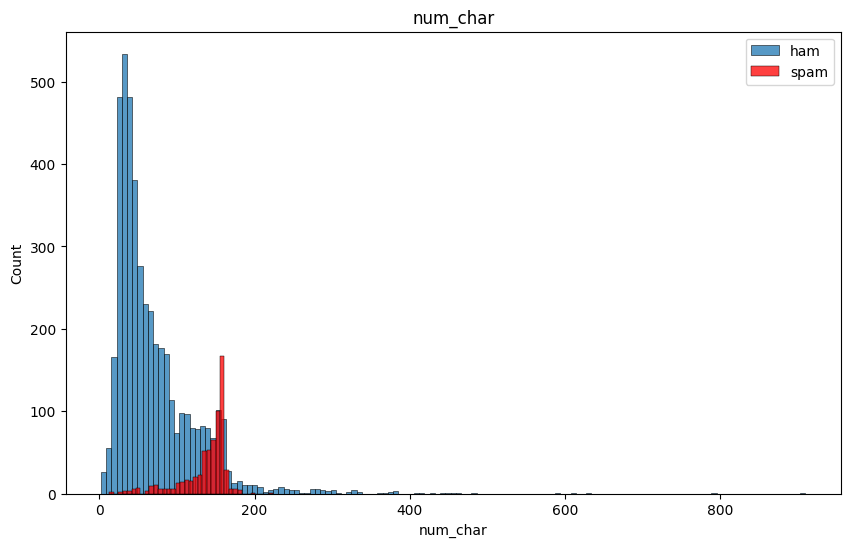

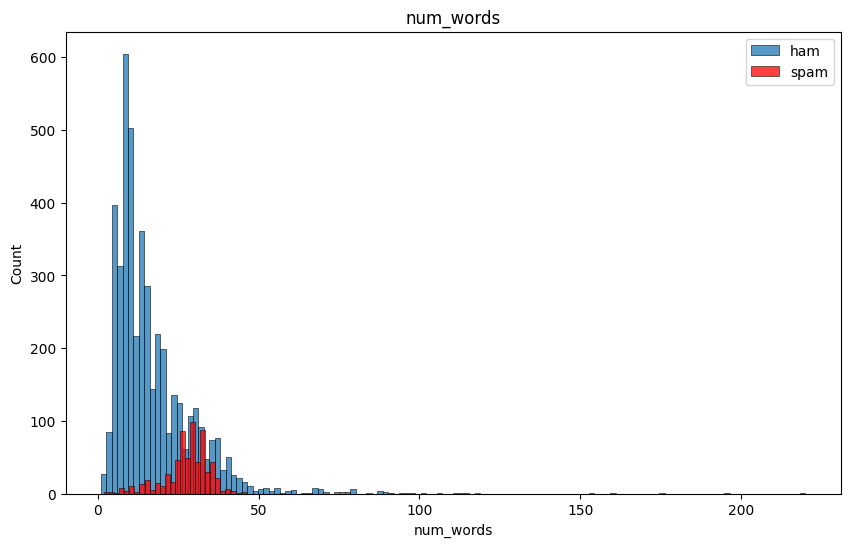

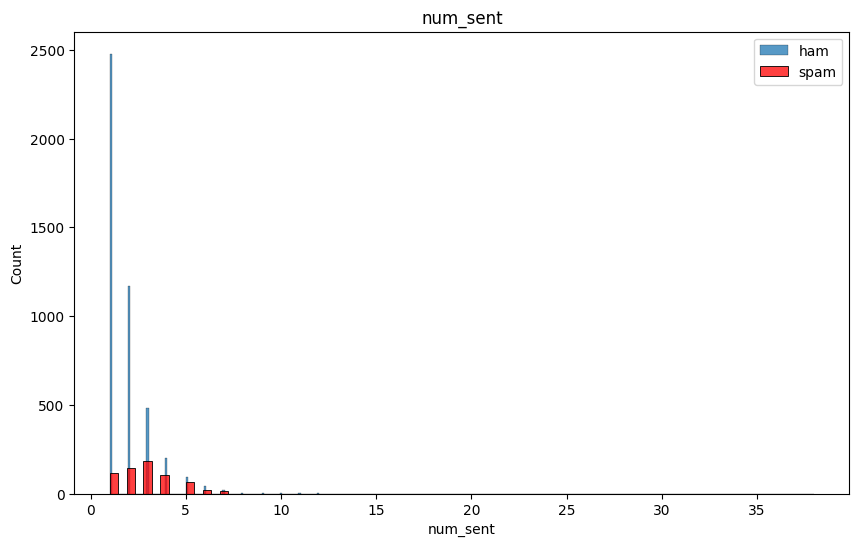

In [20]:
# Function to plot new features with respect to the target column
def plot(dataset):
    for i in dataset.columns.to_list():
        if i in ['num_char','num_words','num_sent']:
            plt.figure(figsize=(10,6))
            sns.histplot(dataset[dataset['target'] == 0][i])
            sns.histplot(dataset[dataset['target'] == 1][i],color='red')
            plt.legend(['ham','spam'])
            plt.title(i)
plot(new_df)

- As we can see maximum "SPAM" sms have more number of characters and words than "HAM" sms

<Axes: >

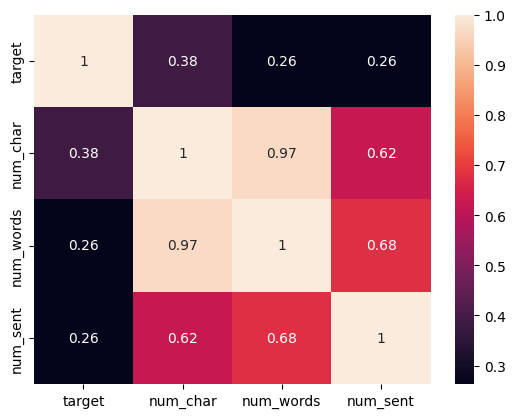

In [21]:
# Viewing correlations between the features
sns.heatmap(new_df.corr(numeric_only=True),annot=True)

- As we can see num_char, num_sent and num_words are highly correlated.

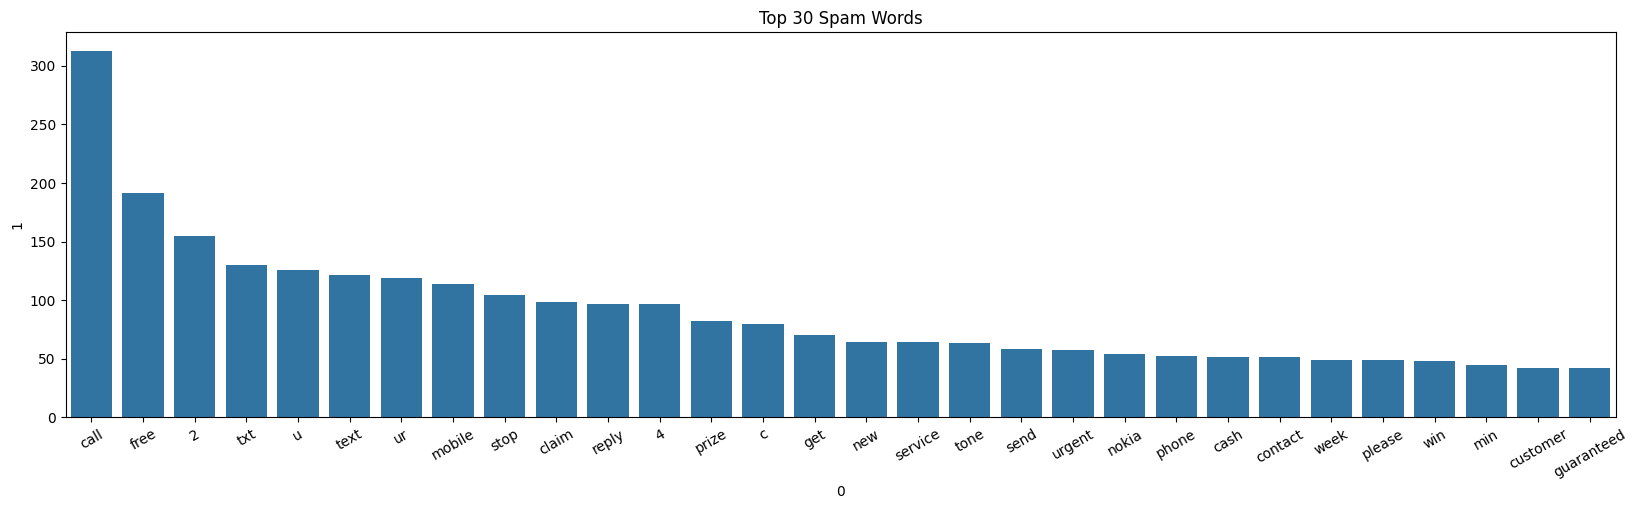

In [22]:
# Viewing top 30 words in SPAM sms
def top_30_spam_words(dataset):
    spam = []
    for text in dataset[dataset['target']==1]['text'].to_list():
        for word in text.split():
            spam.append(word)
    plt.figure(figsize=(20,5))
    sns.barplot(x=pd.DataFrame(Counter(spam).most_common(30))[0],y=pd.DataFrame(Counter(spam).most_common(30))[1])
    plt.xticks(rotation=30)
    plt.title('Top 30 Spam Words')
    plt.show()

top_30_spam_words(new_df)

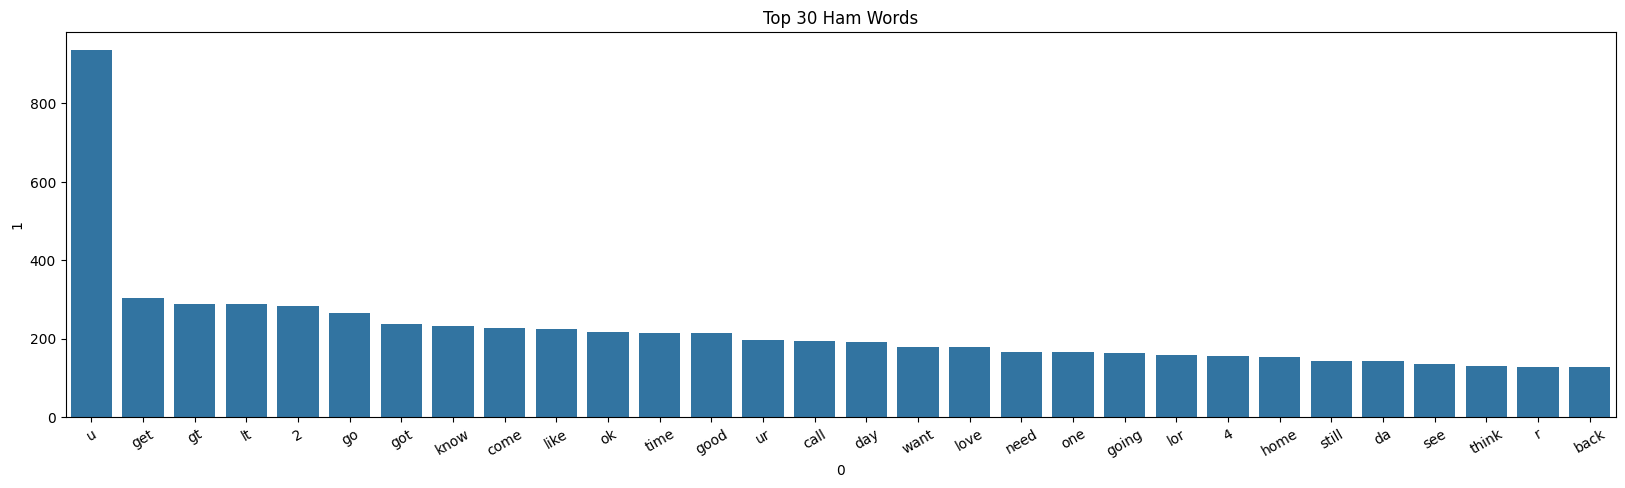

In [23]:
# Viewing top 30 words in HAM sms
def top_30_ham_words(dataset):
    ham = []
    for text in dataset[dataset['target']==0]['text'].to_list():
        for word in text.split():
            ham.append(word)
    plt.figure(figsize=(20,5))
    sns.barplot(x=pd.DataFrame(Counter(ham).most_common(30))[0],y=pd.DataFrame(Counter(ham).most_common(30))[1])
    plt.xticks(rotation=30)
    plt.title('Top 30 Ham Words')
    plt.show()

top_30_ham_words(new_df)

# 8. Vectorization & Data Splitting

In [24]:
# Making object of TfidfVectorizer and MinMaxScalar
tfidf = TfidfVectorizer(max_features=3000)
scaler = MinMaxScaler()

In [25]:
# Vectorizing and splitting prep_df
X_prep = tfidf.fit_transform(prep_df['text']).toarray()
y_prep = prep_df.target

X_prep_train, X_prep_test, y_prep_train, y_prep_test = train_test_split(X_prep, y_prep, test_size=0.20, random_state=2)

In [26]:
# Vectorizing and splitting new_df
X_unscaled = np.hstack((tfidf.fit_transform(new_df['text']).toarray(),new_df['num_words'].values.reshape(-1,1),
                   new_df['num_char'].values.reshape(-1,1),new_df['num_sent'].values.reshape(-1,1)))
X_new = scaler.fit_transform(X_unscaled)
y_new = new_df.target

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.20, random_state=2)

# 9. Model Building

In [27]:
# Defining classifier models
classifiers = {
    'GaussianNB' : GaussianNB(),
    'MultinomialNB' : MultinomialNB(),
    'BernoulliNB' : BernoulliNB(),
    'Logistic' : LogisticRegression(solver='liblinear'),
    'RandomForest' : RandomForestClassifier(n_estimators=100,random_state=2),
    'XGBoost' : XGBClassifier(n_estimators = 100,random_state=2)
}

In [28]:
# Dunction for training
def training(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    F1_score = f1_score(y_test,y_pred)
    return accuracy,precision,F1_score

In [29]:
# Function to get the result
def result(X_train,y_train,X_test,y_test):
    accuracy_scores = []
    precision_scores = []
    F1_scores = []
    for name,clf in classifiers.items():
        current_accuracy,current_precision,current_F1_score = training(clf, X_train,y_train,X_test,y_test)
        accuracy_scores.append(current_accuracy)
        precision_scores.append(current_precision)
        F1_scores.append(current_F1_score)
    return pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'F1_score':F1_scores}).sort_values('Precision',ascending=False)

## 9.1 Dataset With New Features

In [30]:
new_df_performance = result(X_new_train,y_new_train,X_new_test,y_new_test)
new_df_performance

,Algorithm,Accuracy,Precision,F1_score
2,BernoulliNB,0.984526,1.000000,0.938462
4,RandomForest,0.971954,0.990991,0.883534
3,Logistic,0.973888,0.982609,0.893281
1,MultinomialNB,0.978723,0.946154,0.917910
5,XGBoost,0.970986,0.915385,0.888060
0,GaussianNB,0.888781,0.551111,0.683196


## 9.2 Dataset Without New Features

In [31]:
prep_df_performance = result(X_prep_train,y_prep_train,X_prep_test,y_prep_test)
prep_df_performance

,Algorithm,Accuracy,Precision,F1_score
1,MultinomialNB,0.973888,1.000000,0.891566
2,BernoulliNB,0.983559,1.000000,0.934363
3,Logistic,0.953578,0.989130,0.791304
4,RandomForest,0.974855,0.982759,0.897638
5,XGBoost,0.972921,0.958333,0.891473
0,GaussianNB,0.881044,0.534884,0.651558


- Since our BernoulliNB model is giving best Accuracy and F1_score and also perfect Precision so we select BernoulliNB model
- Precision for BernoulliNB is same for both the datasets and Accuracy is also almost equal. So we don't need to extract any feature

In [32]:
model = BernoulliNB()
model.fit(X_prep_train,y_prep_train)

# 10. Model Exporting

In [33]:
joblib.dump(tfidf,'TfIdf.joblib')

In [34]:
joblib.dump(model,'BernoulliNB.joblib')